## Volumetric data processing
This is a simple demo on toy 3d data for source extraction and deconvolution using CaImAn.
For more information check demo_pipeline.ipynb which performs the complete pipeline for
2d two photon imaging data.

In [1]:
#%%


try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

from ipyparallel import Client
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
from scipy.ndimage.filters import gaussian_filter
import sys

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.components_evaluation import evaluate_components, estimate_components_quality_auto
from caiman.cluster import setup_cluster
from caiman.paths import caiman_datadir

import bokeh.plotting as bpl
bpl.output_notebook()
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

1


Loading BokehJS ...

In [2]:
# stop the cluster if one exists
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")
sys.stdout.flush()  
cm.stop_server()

using 8 processes
Stopping  cluster to avoid unnencessary use of memory....


      306745 [cluster.py:         stop_server():314] [14519] Stopping cluster...
      306746 [cluster.py:         stop_server():319] [14519] stop_server: not a slurm cluster
      307115 [cluster.py:         stop_server():353] [14519] No cluster to stop...
      307116 [cluster.py:         stop_server():367] [14519] stop_cluster(): done


Define a function to create some toy data

In [3]:
def gen_data(p=1, noise=1., T=256, framerate=30, firerate=2., plot=False):
    if p == 2:
        gamma = np.array([1.5, -.55])
    elif p == 1:
        gamma = np.array([.9])
    else:
        raise
    dims = (30, 40, 50)  # size of image
    sig = (2, 2, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(7)
    centers = np.asarray([[np.random.randint(5, x - 5)
                           for x in dims] for i in range(N)])
    Yr = np.zeros(dims + (T,), dtype=np.float32)
    trueSpikes = np.random.rand(N, T) < firerate / float(framerate)
    trueSpikes[:, 0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2, T):
        if p == 2:
            truth[:, i] += gamma[0] * truth[:, i - 1] + gamma[1] * truth[:, i - 2]
        else:
            truth[:, i] += gamma[0] * truth[:, i - 1]
    for i in range(N):
        Yr[centers[i, 0], centers[i, 1], centers[i, 2]] = truth[i]
    tmp = np.zeros(dims)
    tmp[15, 20, 25] = 1.
    z = np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Yr = bkgrd + noise * np.random.randn(*(dims + (T,))) + 10 * gaussian_filter(Yr, sig + (0,)) / z
    d1, d2, d3, T = Yr.shape
    Yr = np.reshape(Yr, (d1 * d2 * d3, T), order='F').astype(np.float32)

    if plot:
        Y = np.reshape(Yr, (d1, d2, d3, T), order='F')
        plt.figure(figsize=(15, 3))
        plt.plot(truth.T)
        plt.figure(figsize=(15, 3))
        for c in centers:
            plt.plot(Y[c[0], c[1], c[2]])

        plt.figure(figsize=(15, 4))
        plt.subplot(131)
        plt.scatter(*centers.T[::-1], c='g')
        plt.imshow(Y.max(0).max(-1), cmap='hot')
        plt.title('Max.proj. x & t')
        plt.subplot(132)
        plt.scatter(*centers.T[[2, 0, 1]], c='g')
        plt.imshow(Y.max(1).max(-1), cmap='hot')
        plt.title('Max.proj. y & t')
        plt.subplot(133)
        plt.scatter(*centers.T[[1, 0, 2]], c='g')
        plt.imshow(Y.max(2).max(-1), cmap='hot')
        plt.title('Max.proj. z & t')
        plt.show()

    return Yr, truth, trueSpikes, centers, dims

## Data creation and memory mapping
- create a toy 3d dataset if it doesn't exist.
- perform memory mapping.

In [4]:
plt.close('all')
#%% SAVING TIFF FILE ON A SINGLE MEMORY MAPPABLE FILE
demo_filename = os.path.join(caiman_datadir(), 'example_movies', 'demoMovie3D.tif')
try:
    fname_new = cm.save_memmap([demo_filename], base_name='Yr', is_3D=True, order='C')
except:  # %% create 3d tiff file if not yet existent
    from skimage.external.tifffile import imsave
    Yr, truth, trueSpikes, centers, dims = gen_data(p=2)
    data = np.transpose(Yr.reshape(dims + (-1,), order='F'), [3, 0, 1, 2])
    imsave(demo_filename, data)
    fname_new = cm.save_memmap([demo_filename], base_name='Yr', is_3D=True, order='C')

print(fname_new)

      331867 [mmapping.py:         save_memmap():408] [14519] /Users/pgunn/caiman_data/example_movies/demoMovie3D.tif
      333618 [mmapping.py:         save_memmap():408] [14519] /Users/pgunn/caiman_data/example_movies/demoMovie3D.tif
      333770 [mmapping.py:         save_memmap():472] [14519] SAVING WITH numpy.tofile()


/Users/pgunn/caiman_data/example_movies/Yr_d1_30_d2_40_d3_50_order_C_frames_256_.mmap


Load memory mapped file and show a max-projection of the correlation image

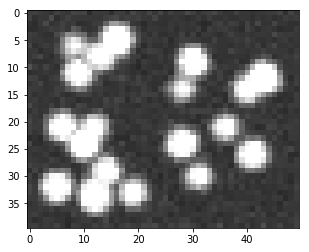

In [5]:
Yr, dims, T = cm.load_memmap(fname_new)
Y = np.reshape(Yr, dims + (T,), order='F')
Cn = cm.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape) == 3 else Cn, cmap='gray',
           vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))
plt.show()

## Run CNMF
### If data is small enough use a single patch approach

In [6]:
# set parameters
K = 20  # number of neurons expected per patch
gSig = [2, 2, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

In [7]:
%%capture
# START CLUSTER
c, dview, n_processes = setup_cluster(
    backend='local', n_processes=None, single_thread=False)

Initialize CNMF object

In [8]:
# INIT
cnm = cnmf.CNMF(n_processes, method_init='greedy_roi', k=K, gSig=gSig, merge_thresh=merge_thresh,
                p=p, dview=dview, Ain=None, method_deconvolution='oasis')

### Run CNMF

In [9]:
%%capture
# FIT
images = np.reshape(Yr.T, [T] + list(dims), order='F')    # reshape data in Python format (T x X x Y x Z)
cnm = cnm.fit(images)

      412804 [cnmf.py:                 fit():400] [14519] (256, 30, 40, 50)
      412805 [cnmf.py:                 fit():421] [14519] Using 8 processes
      412805 [cnmf.py:                 fit():446] [14519] using 4000 pixels per process
      412806 [cnmf.py:                 fit():447] [14519] using 5000 block_size
      412806 [cnmf.py:                 fit():452] [14519] preprocessing ...
      417378 [cnmf.py:                 fit():457] [14519] initializing ...
      418516 [cnmf.py:                 fit():516] [14519] update spatial ...
      430378 [mmapping.py:parallel_dot_product():511] [14519] parallel dot product block size: 5000
      430380 [mmapping.py:parallel_dot_product():526] [14519] Start product
      430401 [mmapping.py:parallel_dot_product():556] [14519] Processed:[0, 12]
      430401 [mmapping.py:parallel_dot_product():565] [14519] Filling
      430481 [cnmf.py:                 fit():520] [14519] update temporal ...
      430482 [cnmf.py:                 fit():526

View components per layer

In [10]:
# view components per layer
traces_fluo = nb_view_patches3d(cnm.YrA, cnm.A, cnm.C,dims, thr=0.9,image_type='max', max_projection=False, denoised_color='red')

## Run CNMF
### For larger data use a patch approach

In [11]:
%%capture
rf = (15, 15, 15)  # half-size of the patches in pixels. rf=25, patches are 50x50
stride = (10, 10, 10)  # amounpl.it of overlap between the patches in pixels
K = 12  # number of neurons expected per patch
gSig = [2, 2, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system
save_results = False
#%% RUN ALGORITHM ON PATCHES
init_method = 'greedy_roi'
alpha_snmf = None  # 10e2  # this controls sparsity

cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=p, dview=dview, Ain=None, rf=rf, stride=stride, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, method_deconvolution='oasis')
cnm = cnm.fit(images)

A_tot = cnm.A
C_tot = cnm.C
YrA_tot = cnm.YrA
b_tot = cnm.b
f_tot = cnm.f
sn_tot = cnm.sn

print(('Number of components:' + str(A_tot.shape[-1])))

      509434 [cnmf.py:                 fit():400] [14519] (256, 30, 40, 50)
      509435 [cnmf.py:                 fit():421] [14519] Using 8 processes
      509436 [cnmf.py:                 fit():446] [14519] using 4000 pixels per process
      509436 [cnmf.py:                 fit():447] [14519] using 5000 block_size
      511105 [cnmf.py:                 fit():634] [14519] merging
      511513 [cnmf.py:                 fit():641] [14519] update temporal
      511525 [mmapping.py:parallel_dot_product():511] [14519] parallel dot product block size: 5000
      511526 [mmapping.py:parallel_dot_product():526] [14519] Start product
      511575 [mmapping.py:parallel_dot_product():556] [14519] Processed:[0, 12]
      511576 [mmapping.py:parallel_dot_product():559] [14519] Transposing


## Component Evaluation

In [12]:
#%% COMPONENT EVALUATION
# the components are evaluated in two ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient

fr = 10 # approx final rate  (after eventual downsampling )
decay_time = 1.  # length of typical transient in seconds 
use_cnn = False  # CNN classifier is designed for 2d (real) data
min_SNR = 3      # accept components with that peak-SNR or higher
rval_thr = 0.7   # accept components iwth speace correlation threshold or higher

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    estimate_components_quality_auto(images, cnm.A, cnm.C, cnm.b, cnm.f, 
                                     cnm.YrA, fr, decay_time, gSig, dims, 
                                     dview = dview, min_SNR=min_SNR, 
                                     r_values_min = rval_thr, use_cnn = use_cnn)

      536770 [components_evaluation.py:estimate_components_quality():696] [14519] EVALUATING IN PARALLEL... NOT RETURNING ERFCs


In [13]:
# evaluate_components
final_frate = 10  # approx final rate  (after eventual downsampling )
Npeaks = 10
traces = C_tot + YrA_tot
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(
    Y, traces, A_tot, C_tot, b_tot, f_tot, final_frate, remove_baseline=False, N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)

idx_components_r = np.where(r_values >= .7)[0]
idx_components_raw = np.where(fitness_raw < -60)[0]
idx_components_delta = np.where(fitness_delta < -20)[0]

idx_components = np.union1d(idx_components_r, idx_components_raw)
idx_components = np.union1d(idx_components, idx_components_delta)
idx_components_bad = np.setdiff1d(list(range(len(traces))), idx_components)

print(('Keeping ' + str(len(idx_components)) +
       ' and discarding  ' + str(len(idx_components_bad))))

      558138 [components_evaluation.py: evaluate_components():370] [14519] tB:-2.0,tA:9.0
      558139 [components_evaluation.py: evaluate_components():375] [14519] Computing event exceptionality delta
      558144 [components_evaluation.py: evaluate_components():379] [14519] Removing Baseline
      558144 [components_evaluation.py: evaluate_components():413] [14519] Computing event exceptionality
      558148 [components_evaluation.py: evaluate_components():417] [14519] Evaluating spatial footprint
      558162 [components_evaluation.py:classify_components_ep():218] [14519] components evaluated:0


Keeping 20 and discarding  1


select only the good components

In [14]:
A_tot = cnm.A[:, idx_components]
C_tot = cnm.C[idx_components]

## Re-run seeded CNMF
Now we re-run CNMF on the whole FOV seeded with `A_tot`

In [15]:
%%capture
# fit good components again
cnm = cnmf.CNMF(n_processes, k=A_tot.shape, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview,
                Ain=A_tot, Cin=C_tot, f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis')
cnm = cnm.fit(images)

      572585 [cnmf.py:                 fit():400] [14519] (256, 30, 40, 50)
      572585 [cnmf.py:                 fit():421] [14519] Using 8 processes
      572586 [cnmf.py:                 fit():446] [14519] using 4000 pixels per process
      572587 [cnmf.py:                 fit():447] [14519] using 5000 block_size
      572587 [cnmf.py:                 fit():452] [14519] preprocessing ...
      572932 [cnmf.py:                 fit():516] [14519] update spatial ...
      584367 [mmapping.py:parallel_dot_product():511] [14519] parallel dot product block size: 5000
      584369 [mmapping.py:parallel_dot_product():526] [14519] Start product
      584391 [mmapping.py:parallel_dot_product():556] [14519] Processed:[0, 12]
      584391 [mmapping.py:parallel_dot_product():565] [14519] Filling
      584460 [cnmf.py:                 fit():520] [14519] update temporal ...
      584460 [cnmf.py:                 fit():526] [14519] deconvolution ...
      584472 [mmapping.py:parallel_dot_product(

## View the results

In [16]:
# view components per layer
traces_fluo = nb_view_patches3d(cnm.YrA, cnm.A, cnm.C, dims, Yr=Yr,
                                image_type='corr', denoised_color='green')

In [17]:
# STOP CLUSTER
cm.stop_server(dview=dview)

      620895 [cluster.py:         stop_server():367] [14519] stop_cluster(): done
